This test shows a more ordinary straight-hodograph supercell thunderstorm in a doubly-periodic domain at 2-km resolution. This is a useful test to demonstrate the effect of condensate loading on the pressure, and to show how using the "nonhydrostatic perturbation" can be misleading if one does not understand what is being perturbed against. We then explore sensitivity to condensate loading and to the moist (variable) $\kappa$.

In [1]:
import xarray as xa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
import matplotlib.colors as colors

In [2]:
large = 16; med = 12; small = 10
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (8, 4),
          'axes.labelsize': med,
          'axes.titlesize': large,
          'xtick.labelsize': small,
          'ytick.labelsize': small,
          'figure.titlesize': large,
          'axes.titlepad': 6}
plt.rcParams.update(params)

In [3]:
#ds = xa.open_dataset('/archive/Lucas.Harris/SHiELD/202009c/20160621.00Z.d96_2k.bubble.make_res/history/2016062100/atmos_hifreq.nc',decode_times=False,chunks={'time': 1}) #to be replaced with a solo-core run
ds = xa.open_dataset('atmos_hifreq.nc',decode_times=False,chunks={'time': 1})

We can compute surface pressure perturbation in three ways:

1. Surface hydrostatic pressure (ie column atmosphere mass) perturbation from the background state ($\sum \delta p^* - p^*_{s0}$)
2. Lowest-layer full pressure (computed from ideal gas law) perturbation from background state ($p - p_0 = \frac{\delta p^*}{g\delta z}R_d T_v - p_0$)
3. Lowest-layer nonhydrostatic component, difference of ideal gas law pressure from hydrostatic cell-mean pressure $p-p^*$, where $p^* = \frac{\delta p}{\delta \log p}$ *not* $0.5\left ( p^*_B + p^*_T\right )$

It is apparent these are not the same thing. In some places a *positive* hydrostatic perturbation exists with a *negative* nonhydrostatic component!!

**NOTE**: Here we define *perturbation* to mean deviation from the mean initial state, while *component* means a partitioning of the instantaneous pressure into its parts (nonhydrostatic, contributions from different tracer masses, etc.)

**NOTE #2**: In SHiELD and the UFS the the output of delp and pressure variables are re-scaled to be moist mass, to be consistent with NCEP validations. This is controlled by the GFS_PHYS compiler directive. So results from full-physics runs may differ from those shown here. However the nonhydrostatic component (ppnh) is correctly computed to be relative to total-mass hydrostatic pressure.

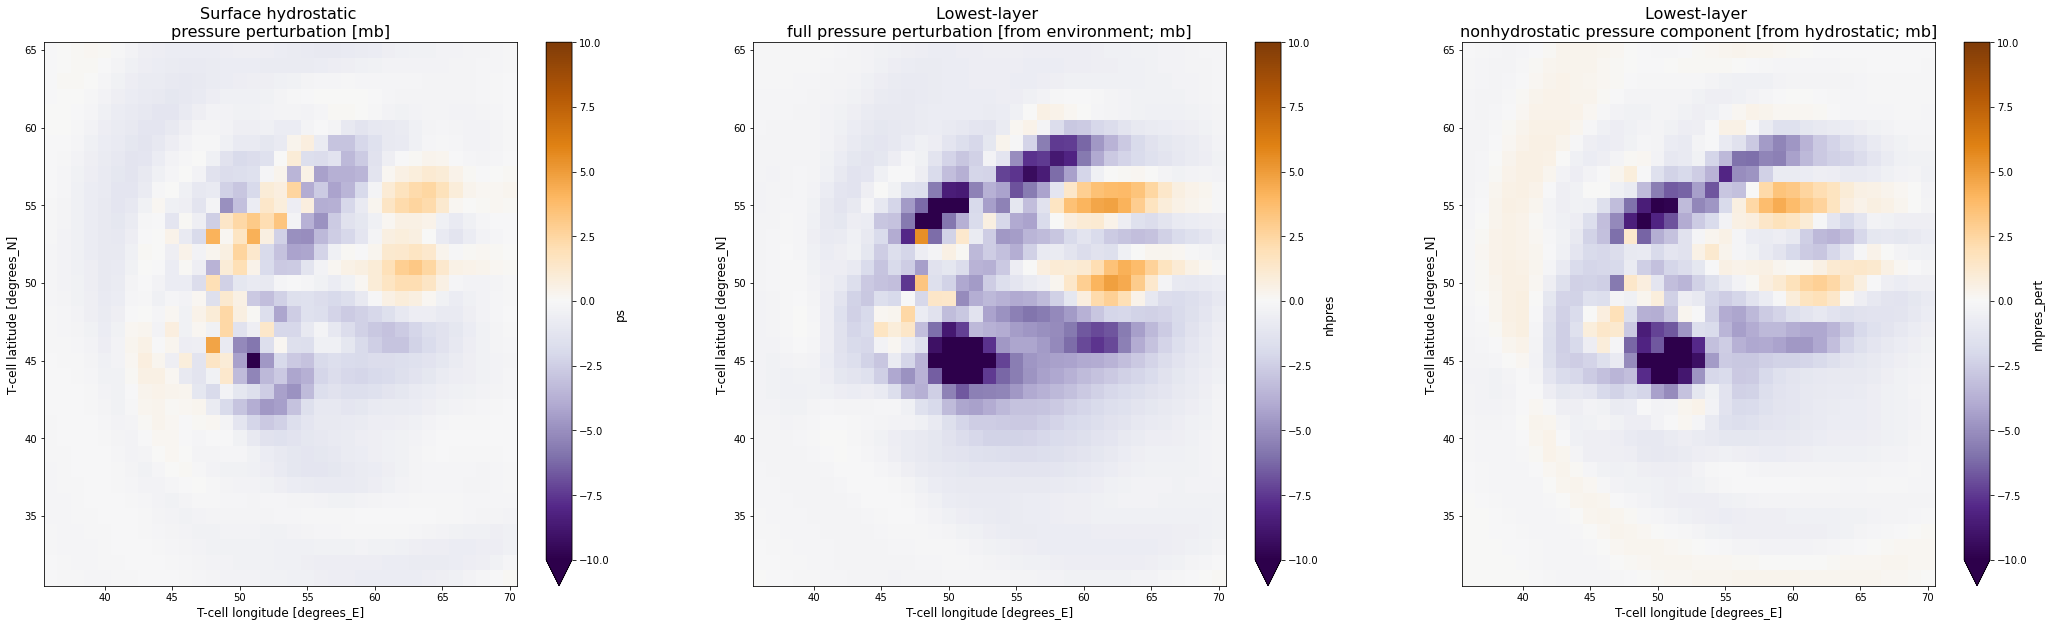

In [4]:
t=16
ds_small=ds.isel(time=t,grid_xt=slice(35,70),grid_yt=slice(30,65))
ds_ref=ds.isel(time=0,grid_xt=0,grid_yt=0)

fig=plt.figure(figsize=(36,10))
ax = fig.add_subplot(1,3,1)
((ds_small.ps-ds_ref.ps)/1.e2).plot(ax=ax,vmax=10,vmin=-10,cmap=plt.get_cmap('PuOr_r'))
ax.set_title("Surface hydrostatic \npressure perturbation [mb]")
ax = fig.add_subplot(1,3,2)
( (ds_small.nhpres[-1,:,:]-ds_ref.nhpres[-1])/1.e2).plot(ax=ax,vmax=10,vmin=-10,cmap=plt.get_cmap('PuOr_r'))
ax.set_title("Lowest-layer \nfull pressure perturbation [from environment; mb]")
ax = fig.add_subplot(1,3,3)
( (ds_small.nhpres_pert[-1,:,:])/1.e2).plot(ax=ax,vmax=10,vmin=-10,cmap=plt.get_cmap('PuOr_r'))
ax.set_title("Lowest-layer \nnonhydrostatic pressure component [from hydrostatic; mb]");


What's going on? It helps to ask what we mean by "pressure" in the first place. In a hydrostatic run the pressure is just the mass of air *above* a grid cell, but in the nonhydrostatic solver the pressure is computed from the ideal gas law. The nonhydrostatic perturbation is the difference between these...but in FV3 the air mass includes water vapor and **all** hydrometeors. So if water mass is added to a cell in the column, then the hydrostatic pressure increases for *all* layers below the cell, and since the terms in the ideal gas law are unchanged, the total pressure stays the same and the nonhydrostatic pressure **decreases**!!

The NH perturbation is important for computing the vertical velocity (see below), but this is not something that we would typically measure in a real thunderstorm. There, the "perturbation" pressure is more like #1 above, measured by a barometer on or near the ground.

These figures show the amount of additional mass in the column from water vapor anomalies and condensates, re-scaled into contribution to hydrostatic pressure. In this example this can be up to 10 mb!

Text(0.5, 1.0, 'Perturbation column total water component [mb]')

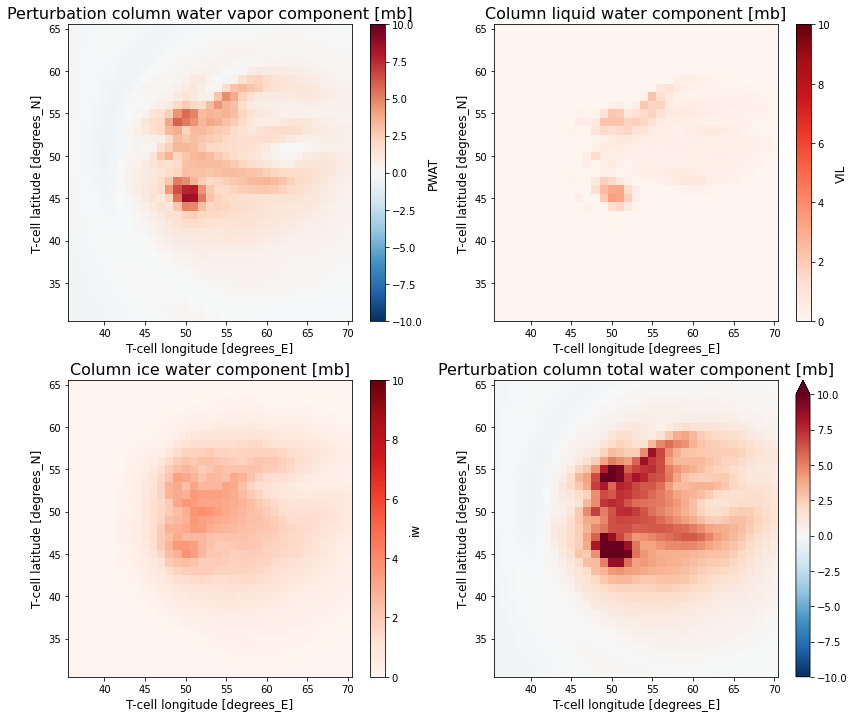

In [11]:
#Mass Components (note PWAT, VIL, IW all in units of kg/m**2 so conversion is easy)
grav = 9.81 #m/s
Mv = ds_small.PWAT*grav/100. - ds_ref.PWAT*grav/100.
Ml = ds_small.VIL*grav/100.
Mi = ds_small.iw*grav/100.

fig = plt.figure(figsize=(14,12))
ax = fig.add_subplot(2,2,1)
(Mv).plot(ax=ax,vmax=10,vmin=-10,cmap=plt.get_cmap('RdBu_r'))
ax.set_title("Perturbation column water vapor component [mb]")

ax = fig.add_subplot(2,2,2)
Ml.plot(ax=ax,vmax=10,cmap=plt.get_cmap('Reds'))
ax.set_title("Column liquid water component [mb]")

ax = fig.add_subplot(2,2,3)
Mi.plot(ax=ax,vmax=10,cmap=plt.get_cmap('Reds'))
ax.set_title("Column ice water component [mb]")

ax = fig.add_subplot(2,2,4)
(Mv + Ml + Mi).plot(ax=ax,vmax=10,vmin=-10,cmap=plt.get_cmap('RdBu_r'))
ax.set_title("Perturbation column total water component [mb]")


We can now partition the lowest-layer and surface pressures into their components. 

In [12]:
phalf = ds_small.phalf

ptop=phalf[0]
phalf=phalf[1:]
phyd=ds_small.delp.sum(dim="pfull") + ptop
phyd_ref=ds_ref.delp.sum(dim="pfull") + ptop
psphum=((ds_small.sphum)*ds_small.delp).sum(dim="pfull")
psphum_ref=((ds_ref.sphum)*ds_ref.delp).sum(dim="pfull")

#qp and qn are **weight** per grid cell and not specific ratios
pcond=((ds_small.qp + ds_small.qn)).sum(dim="pfull")


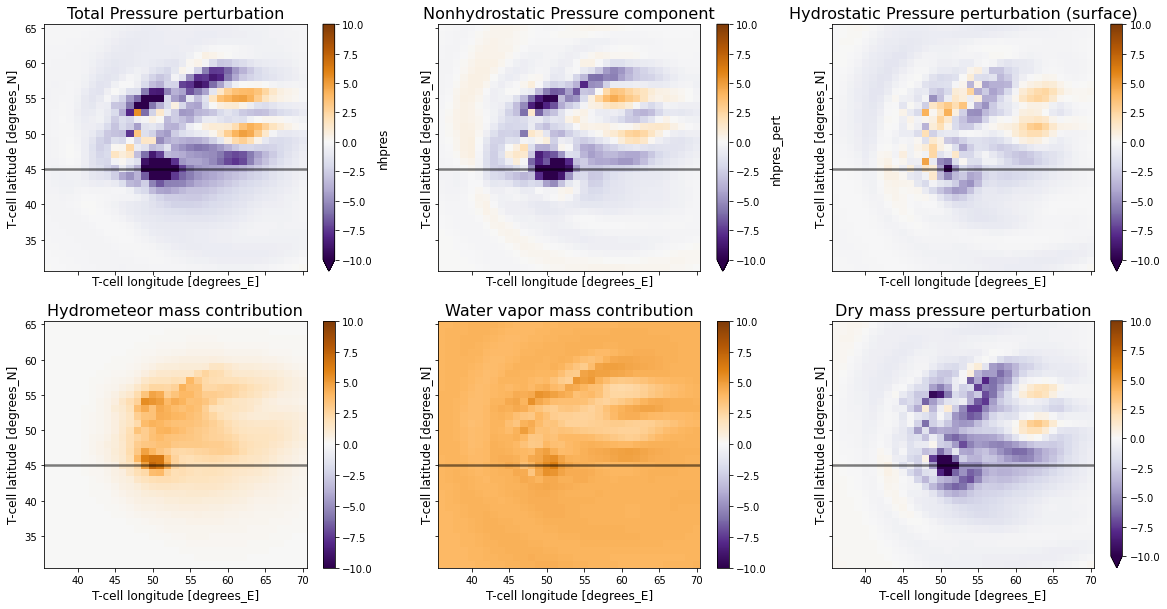

In [41]:

#fig = plt.figure(figsize=(20,10))
fig,ax = plt.subplots(2,3,sharex='col',sharey='row',figsize=(20,10))

#nhpres anom
#ax = fig.add_subplot(2,3,1)
((ds_small.nhpres[-1,:,:]-ds_ref.nhpres[-1])/100.).plot(ax=ax[0,0],vmax=10,vmin=-10,cmap=plt.get_cmap('PuOr_r'))
ax[0,0].set_title("Total Pressure perturbation")

#nhpres_pert
((ds_small.nhpres_pert[-1,:,:])/100.).plot(ax=ax[0,1],vmax=10,vmin=-10,cmap=plt.get_cmap('PuOr_r'))
ax[0,1].set_title("Nonhydrostatic Pressure component")

((phyd-phyd_ref)/100.).plot(ax=ax[0,2],vmax=10,vmin=-10,cmap=plt.get_cmap('PuOr_r'))
ax[0,2].set_title("Hydrostatic Pressure perturbation (surface)")

#hydrometeors
(pcond/100.).plot(ax=ax[1,0],vmax=10,vmin=-10,cmap=plt.get_cmap('PuOr_r'))
ax[1,0].set_title("Hydrometeor mass contribution")

#dry pressure perturbation
((psphum)/100.).plot(ax=ax[1,1],vmax=10,vmin=-10,cmap=plt.get_cmap('PuOr_r'))
ax[1,1].set_title("Water vapor mass contribution");

#dry pressure perturbation
((phyd-(phyd_ref-psphum_ref)-pcond-psphum)/100.).plot(ax=ax[1,2],vmax=10,vmin=-10,cmap=plt.get_cmap('PuOr_r'))
ax[1,2].set_title("Dry mass pressure perturbation");

#Add location of cross section
#NOTE: apparently this behavior will change in a future version of Matplotlib
#  so if it makes empty plots then just remove it.
ycross=45
for n in range(2):
    for m in range(3):
        ax[n,m].plot(ax[n,m].get_xlim(),[ycross,ycross],color='k',linewidth=2.5,alpha=0.5)

Here we see that the total pressure and dry mass pressure perturbation minima are co-located under the storm cloud, but ahead (east) of the storm there are anticorrelated nonhydrostatic components and hydrostatic pressure perturbations which cancel each other out. Meanwhile the nonhydrostatic pressure perturbation is primarily along the outside flanks of the storm with relatively small values in the interior of the cloud.

A vertical east-west cross-section across the outward flank of the southern storm (black line in the above figure) through the NH component maxima makes the nature of the perturbations clear.

In [45]:
#Calculate hydrostatic pressure on lower interfaces (note this is not layer mean)
#ds_cross=ds_small.sel(grid_xt=30)#,grid_xt=slice(50,70)) #farther away
ds_cross=ds_small.sel(grid_yt=ycross)#,grid_xt=slice(50,70)) #farther away

ptop=phalf[0]
phalf=phalf[1:]
xphyd=ds_cross.delp.cumsum(dim="pfull") + ptop
xphyd_ref=ds_ref.delp.cumsum(dim="pfull") + ptop
xpsphum=((ds_cross.sphum)*ds_cross.delp).cumsum(dim="pfull")
xpsphum_ref=((ds_ref.sphum)*ds_ref.delp).cumsum(dim="pfull")
xpcond=(ds_cross.qp + ds_cross.qn).cumsum(dim="pfull")


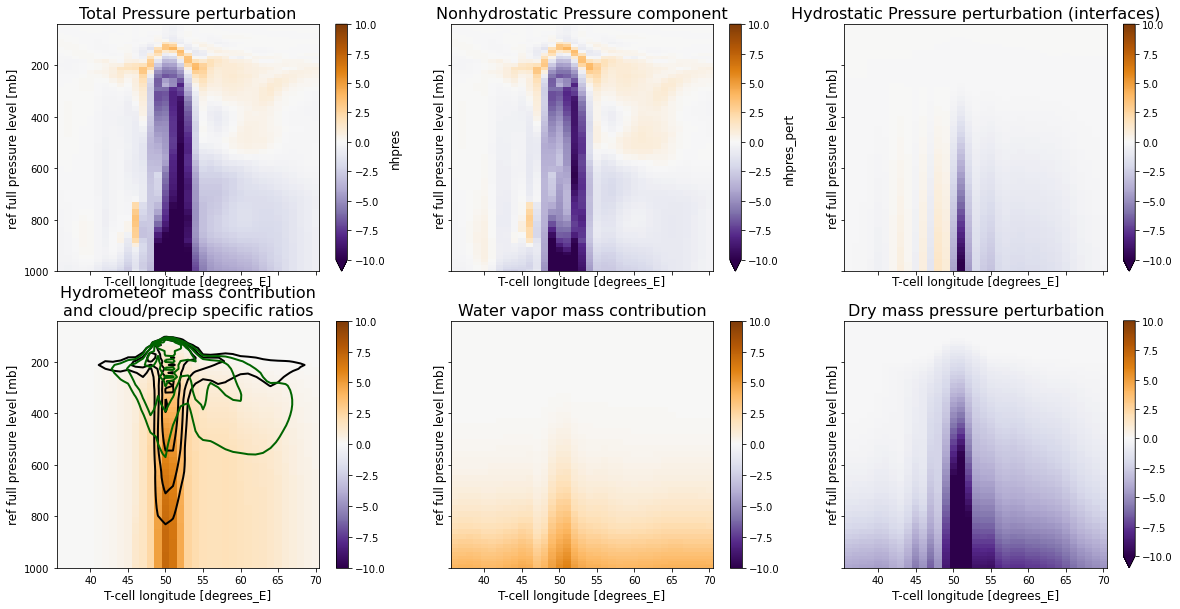

In [46]:
#fig = plt.figure(figsize=(20,10))
fig,ax = plt.subplots(2,3,sharex='col',sharey='row',figsize=(20,10))
#nhpres anom
((ds_cross.nhpres-ds_ref.nhpres)/100.).plot(ax=ax[0,0],yincrease=False,vmax=10,vmin=-10,cmap=plt.get_cmap('PuOr_r'))
ax[0,0].set_title("Total Pressure perturbation")

#nhpres_pert
((ds_cross.nhpres_pert)/100.).plot(ax=ax[0,1],yincrease=False,vmax=10,vmin=-10,cmap=plt.get_cmap('PuOr_r'))
ax[0,1].set_title("Nonhydrostatic Pressure component")


#phyd=(ds_cross.nhpres-ds_ref.nhpres-ds_cross.nhpres_pert)
((xphyd-xphyd_ref)/100.).plot(ax=ax[0,2],yincrease=False,vmax=10,vmin=-10,cmap=plt.get_cmap('PuOr_r'))
ax[0,2].set_title("Hydrostatic Pressure perturbation (interfaces)")

#hydrometeors
qq=np.cumsum(ds_cross.qp + ds_cross.qn,axis=0)
cloud=ds_cross.qn/ds_cross.delp*1000. #g/kg 
prec=ds_cross.qp/ds_cross.delp*1000.

(xpcond/100.).plot(ax=ax[1,0],yincrease=False,vmax=10,vmin=-10,cmap=plt.get_cmap('PuOr_r'))
vvc=cloud.plot.contour(ax=ax[1,0],yincrease=False,colors='k',levels=np.arange(2,10,2),linewidths=2)
vvp=prec.plot.contour(ax=ax[1,0],yincrease=False,colors='darkgreen',levels=np.arange(2,15,2),linewidths=2)
ax[1,0].set_title("Hydrometeor mass contribution\nand cloud/precip specific ratios")


((xpsphum)/100.).plot(ax=ax[1,1],yincrease=False,vmax=10,vmin=-10,cmap=plt.get_cmap('PuOr_r'))
ax[1,1].set_title("Water vapor mass contribution");

#dry pressure perturbation
((xphyd-xphyd_ref-xpcond-xpsphum)/100.).plot(ax=ax[1,2],yincrease=False,vmax=10,vmin=-10,cmap=plt.get_cmap('PuOr_r'))
ax[1,2].set_title("Dry mass pressure perturbation");

#NOTE: apparently this behavior will change in a future version of Matplotlib
#  so if it makes empty plots then just remove it.
#for n in range(2):
#    for m in range(3):
#        ax[n,m].plot(ax[n,m].get_xlim(),[ycross,ycross],color='k',linewidth=2.5,alpha=0.5)

In these cross sections, it is apparent that:
- The nonhydrostatic pressure minimum ahead (east) of the storm is being cancelled by the mass of hydrometeors increasing the hydrostatic pressure.
- The hydrometeors also partially cancel the loss of dry mass within the storm. 
- This hydrostatic pressure increase affects all layers *below* the cloud
- As a result, this makes weird-looking columnar negative perturbations to "nonhydrostatic pressure". 

So what is nonhydrostatic pressure for? It is used to compute the vertical accelerations through $\frac{dw}{dt} = \delta_z p'$, so only the vertical gradient is important. The absolute value of the nonhydrostatic perturbation is irrelevant. (The horizontal PGF uses the full pressure, albeit partitioned to improve the accuracy of the calculation.) In this example, we would see that the presence of hydrometeors would locally increase the upward NH pressure gradient and create a downward acceleration. This effect is called condensate loading.

We can turn off the mass contribution of water vapor and hydrometeors to mass (and thereby to the pressure gradient forces) by setting nwat = 0. We see much less cancellation of the nonhydrostatic component and the hydrostatic pressure perturbation, but also a weaker set of storms.

In [61]:
t=16
ds_n0 = xa.open_dataset('/archive/Lucas.Harris/SHiELD/202103/d96_2k.solo.bubble.n0//history/0000000000/atmos_hifreq.nc',decode_times=False,chunks={'time': 1})
ds_n0_small=ds_n0.isel(time=t,grid_xt=slice(20,50),grid_yt=slice(33,63))
ds_n0_ref=ds_n0.isel(time=0,grid_xt=0,grid_yt=0)

fig=plt.figure(figsize=(36,10))
ax = fig.add_subplot(1,3,1)
((ds_n0_small.ps-ds_n0_ref.ps)/1.e2).plot(ax=ax,vmax=10,vmin=-10,cmap=plt.get_cmap('PuOr_r'))
ax.set_title("Surface hydrostatic \npressure perturbation [mb]")
ax = fig.add_subplot(1,3,2)
( (ds_n0_small.nhpres[-1,:,:]-ds_n0_ref.nhpres[-1])/1.e2).plot(ax=ax,vmax=10,vmin=-10,cmap=plt.get_cmap('PuOr_r'))
ax.set_title("Lowest-layer \nfull pressure perturbation [from environment; mb]")
ax = fig.add_subplot(1,3,3)
( (ds_n0_small.nhpres_pert[-1,:,:])/1.e2).plot(ax=ax,vmax=10,vmin=-10,cmap=plt.get_cmap('PuOr_r'))
ax.set_title("Lowest-layer \nnonhydrostatic pressure component [from hydrostatic; mb]");


FileNotFoundError: [Errno 2] No such file or directory: b'/archive/Lucas.Harris/SHiELD/202103/d96_2k.solo.bubble.n0/history/0000000000/atmos_hifreq.nc'

# Integrated metrics
We compute maximum values and sums to indicate the relative strengths of the storms with and without condensate loading.


In [75]:
ds_ave = xa.open_dataset('/archive/Lucas.Harris/SHiELD/202103/d96_2k.solo.bubble//history/0000000000/atmos_hifreq_ave.nc',decode_times=False,chunks={'time': 1})
ds_ave_n0 = xa.open_dataset('/archive/Lucas.Harris/SHiELD/202103/d96_2k.solo.bubble.n0/history/0000000000/atmos_hifreq_ave.nc',decode_times=False,chunks={'time': 1})

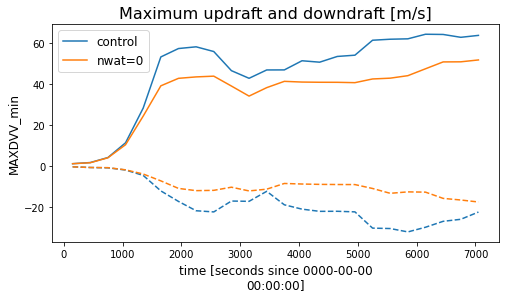

In [104]:
cc=(ds_ave.MAXUVV_max).max(dim=("grid_xt","grid_yt")).plot(label="control")
ds_ave.MAXDVV_min.min(dim=("grid_xt","grid_yt")).plot(color=cc[0].get_color(),linestyle='--')
cc=(ds_ave_n0.MAXUVV_max).max(dim=("grid_xt","grid_yt")).plot(label="nwat=0")
ds_ave_n0.MAXDVV_min.min(dim=("grid_xt","grid_yt")).plot(color=cc[0].get_color(),linestyle='--')
plt.gca().legend();
plt.gca().set_title("Maximum updraft and downdraft [m/s]");

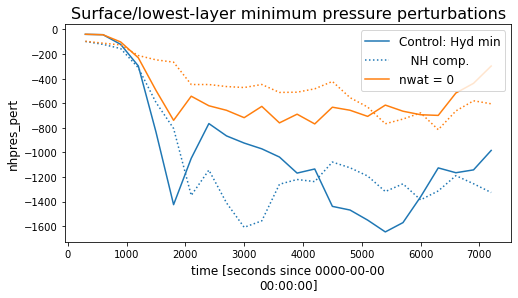

In [126]:
cc=(ds.PRESsfc-1.e5).min(dim=("grid_xt","grid_yt")).plot(label="Control: Hyd min")
(ds.nhpres_pert).isel(pfull=-1).min(dim=("grid_xt","grid_yt")).plot(color=cc[0].get_color(),linestyle=':',label="   NH comp.")
cc=(ds_n0.PRESsfc-1.e5).min(dim=("grid_xt","grid_yt")).plot(label="nwat = 0")
(ds_n0.nhpres_pert).isel(pfull=-1).min(dim=("grid_xt","grid_yt")).plot(color=cc[0].get_color(),linestyle=':')
plt.gca().legend();
plt.gca().set_title("Surface/lowest-layer minimum pressure perturbations");

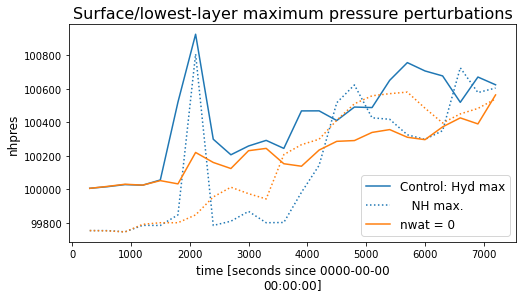

In [130]:
cc=(ds.PRESsfc).max(dim=("grid_xt","grid_yt")).plot(label="Control: Hyd max")
(ds.nhpres).isel(pfull=-1).max(dim=("grid_xt","grid_yt")).plot(color=cc[0].get_color(),linestyle=':',label="   NH max.")
cc=(ds_n0.PRESsfc).max(dim=("grid_xt","grid_yt")).plot(label="nwat = 0")
(ds_n0.nhpres).isel(pfull=-1).max(dim=("grid_xt","grid_yt")).plot(color=cc[0].get_color(),linestyle=':')
plt.gca().legend();
plt.gca().set_title("Surface/lowest-layer maximum pressure perturbations");

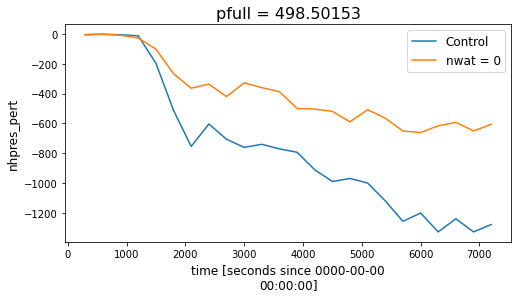

In [135]:
#Mid-level pressure 
ds_mid = ds.sel(pfull=500.,method="nearest")
ds_n0_mid = ds_n0.sel(pfull=500.,method="nearest")

ds_mid.nhpres_pert.min(dim=("grid_xt","grid_yt")).plot(label="Control")
ds_n0_mid.nhpres_pert.min(dim=("grid_xt","grid_yt")).plot(label="nwat = 0")
plt.gca().legend();

It is now apparent that condensate loading is able to enhance pressure gradients and allows development of greater mid-level vertical pressure gradients to enhance updrafts. It is notable that this is despite similar total condensate mass and precipitation in the two simulations.

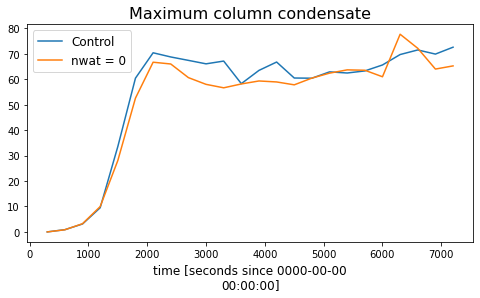

In [125]:
(ds.VIL+ds.iw).max(dim=("grid_xt","grid_yt")).plot(label="Control")
(ds_n0.VIL+ds_n0.iw).max(dim=("grid_xt","grid_yt")).plot(label="nwat = 0")
plt.gca().legend();
plt.gca().set_title("Maximum column condensate");

A final question: What do updrafts look like? 

In [60]:
t=16
ds_ave_small=ds_ave.isel(time=t,grid_xt=slice(20,50),grid_yt=slice(33,63))

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1,2,1)
ds_ave_small.MAXUVV_max.plot(ax=ax)

ax = fig.add_subplot(1,2,2)
ds_ave_small.MAXDVV_min.plot(ax=ax)

NameError: name 'ds_ave' is not defined

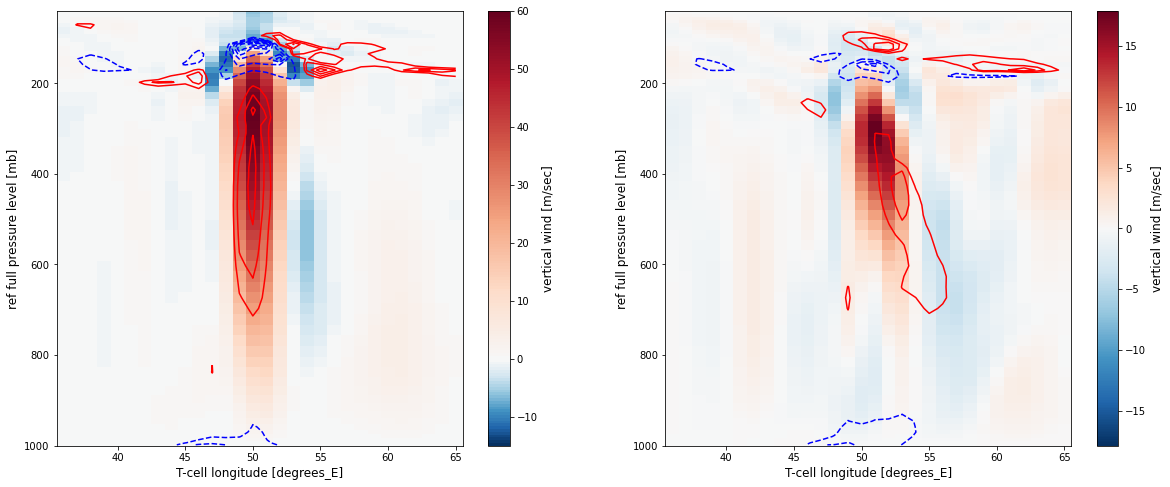

In [74]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1,2,1)
arr = np.flip(np.append(np.linspace(0,0.5,124),np.linspace(0.5,1.0,31)))
cmap = plt.get_cmap('RdBu')
newcolors = cmap(arr)
newcmp = colors.ListedColormap(newcolors)

ds_upcross=ds.isel(time=t,grid_xt=slice(35,65),grid_yt=45)
ds_upcross.w.plot(ax=ax,cmap=newcmp,vmax=60,vmin=-15)
(ds_upcross.temp-ds_ref.temp).plot.contour(yincrease=False,colors='r',levels=np.arange(4,14,2),ax=ax)
(ds_upcross.temp-ds_ref.temp).plot.contour(yincrease=False,colors='b',levels=np.arange(-30,0,5),ax=ax)

ax = fig.add_subplot(1,2,2)

ds_dncross=ds.isel(time=t,grid_xt=slice(35,65),grid_yt=51)
ds_dncross.w.plot(ax=ax)
(ds_dncross.temp-ds_ref.temp).plot.contour(yincrease=False,colors='r',levels=np.arange(4,14,2),ax=ax)
(ds_dncross.temp-ds_ref.temp).plot.contour(yincrease=False,colors='b',levels=np.arange(-30,0,5),ax=ax)

<Figure size 1440x576 with 0 Axes>

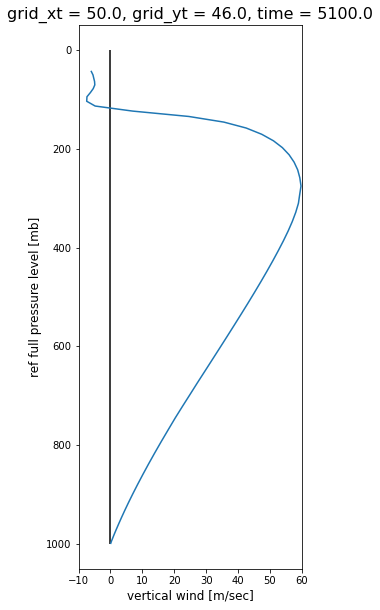

In [81]:
ds_up=ds_upcross.sel(grid_xt=50)
fig = plt.figure(figsize=(20,8))
ds_up.w.plot(y="pfull",yincrease=False,figsize=(4,10),xlim=[-10,60])
plt.vlines(0.0,0,1000,'k')

From these plots the buoyant updrafts are clearly visible, and that they peak in strength in the upper troposphere is also apparent. In the absence of lateral entrainment, we expect parcels should accelerate until they reach their equilibrium level. In particular, a model that produced a mature updraft with a peak vertical velocity in the lower troposphere is unphysical, and could be a sign of severe unphysical vertical diffusivity.

Oscillations at the top of the updraft also create gravity waves, which are clearly visible in the temperature perturbation field. 